In [1]:
from tensorflow import keras
import tensorflow as tf

# This notebook contains notes on all steps necessary to understand encoder-decoder architecture with attention that uses LSTMs as building blocks.

## 1. Keras basics
Keras gives simple API to programming neural networks with tensorflow. This section will provide quick overview of most important features used in code. More detailed explanations can be found [here](https://www.tensorflow.org/guide/keras). Important feature (in terms of understanding Keras code) is that Keras doesn't need input shape of NN to be specified, it can be determined during runtime, so usually Input layer is omitted.
### How to create models - Sequential model
Sequential model provides simple way to program neural networks that can be modeled as stack of layers. Example code that models NN with hidden layer of 3 neurons (relu activation) and output of 2 neurons:

In [2]:
model = keras.Sequential(
    [
        keras.layers.Dense(3, activation="relu", name="hidden"),
        keras.layers.Dense(2, name="output"),
    ])

Model created above can be called on input $x$ with shape 3x3 (for example batch_size x n_features)

In [4]:
x = tf.ones((3, 3))
y = model(x)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (3, 3)                    12        
                                                                 
 output (Dense)              (3, 2)                    8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________




Another way to create such model is to create and add layers separately.

In [7]:
model = keras.Sequential()
hidden = keras.layers.Dense(3, activation="relu", name="hidden")
model.add(hidden)
out = keras.layers.Dense(2, name="output")
model.add(out)


x = tf.ones((3, 3))
y = model(x)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (3, 3)                    12        
                                                                 
 output (Dense)              (3, 2)                    8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


### How to create models - Functional API
Functional API enables creation of more complicated models - ones that cannot be modeled as stack of layers (for example ones that take more than one input). Let's create model that takes 10-dimensional vector as input, feeds it into dense layer with 4 neurons and outputs 1 neuron. Here we create layers separately and link them using call operator. Since here input is defined explicitly, we can show summary before feeding real data to model - that's why layer output shapes have None - to accommodate batch size. 

In [28]:
inputs = keras.Input(shape=(10,), name="inputs")
hidden = keras.layers.Dense(4, activation="relu", name="hidden")(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 hidden (Dense)              (None, 4)                 44        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


### How to train models
To train model, first it needs to be compiled. We can specify optimizer used and cost function.

In [23]:

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

Then we can fit model. Train data, validation data, batch size and number of epochs can be specified. Train data can be either passed as x_train and y_train or as tf.dataset

In [25]:
# prepare data
x_train = tf.ones((10, 10))
y_train = tf.ones((10, 1))
x_val = tf.ones((1, 10))
y_val = tf.ones((1, 1))

print("fit by passing x_train, y_train")
model.fit(x_train, y_train, batch_size=2,  epochs=1, validation_data=(x_val, y_val))

print("fit with dataset")
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
model.fit(dataset, epochs=1)

fit by passing x_train, y_train
5/5 [==============================] - 0s 18ms/step - loss: 0.9075 - val_loss: 0.9018
fit with dataset
5/5 [==============================] - 0s 2ms/step - loss: 0.8980


## 2. Dense NNs vs RNNs
Note: biases are omitted in all calculations and pictures to simplify a little bit

### Simplest case - Dense Neural Network
The simplest NN is a dense one - it takes some inputs $x$, has some hidden neurons $h$ and produces some output $y$. It has 2 sets of weights:
- $W_{xh}$ that are applied to input
- $W_{hy}$ that are applied to hidden state before producing output
  
Picture below portraits dense neural network with one hidden layer

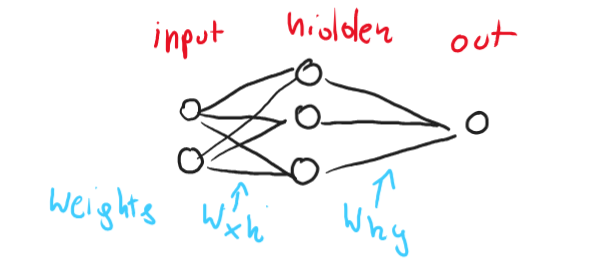

Or, in simplified form it can be pictured as:

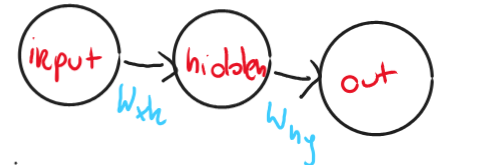

During forward pass such neural network does following computations:
1) compute hidden activations $h = tanh(x \cdot W_{xh})$*
2) produce output $ y = h \cdot W_{hy}$
   
\* tanh is used as activation function, but it can be anything (relu/sigmoid)

In dense NNs hidden layer can have different shape than input. If for example we have 10-dimensional input, 4 hidden neurons and 1 output, shapes of NN components are:
- $x$ = (n_batches, 10) - input
- $W_{xh}$ = (10, 4)
- $h$ = (n_batches, 4) - hidden layer output
- $W_{hy}$ = (4, 1)
- $y$ = (n_batches, 1) - output

Below is example code that defines such network

In [29]:
inputs = keras.Input(shape=(10,), name="inputs")
hidden = keras.layers.Dense(4, activation="relu", name="hidden")(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 hidden (Dense)              (None, 4)                 44        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


To apply dense NNs for time series prediction, first data needs to be properly prepared due to the fact, that dense NNs take input of fixed size. If for example we have 14 data points and we want to predict 1 timestamp ahead based on 10 previous timestamps, 3 training samples would be generated from our dataset.

In [42]:
import numpy as np
window_size = 10

raw_data = np.random.rand(14)
dataset = np.lib.stride_tricks.sliding_window_view(raw_data[:-1], (window_size + 1, ))
x = dataset[:, :-1]
y = dataset[:, -1]
print(f'X shape: {x.shape}, Y shape: {y.shape}. Got {y.shape[0]} batches')

X shape: (3, 10), Y shape: (3,). Got 3 batches


### Recurrent Neural Networks
Most basic RNN can be defined as series of cells, where each cell takes input $x$, returns output $y$ and in each time step passes hidden state $h$ to next time step. This neural network architecture includes 3 sets of weights: 
- $W_{hh}$ that are applied to hidden state passed from previous timestep
- $W_{xh}$ that are applied to input at each timestep
- $W_{hy}$ that are applied to hidden state before producing output at each timestep


Below picture shows whole architecture in a compact way.

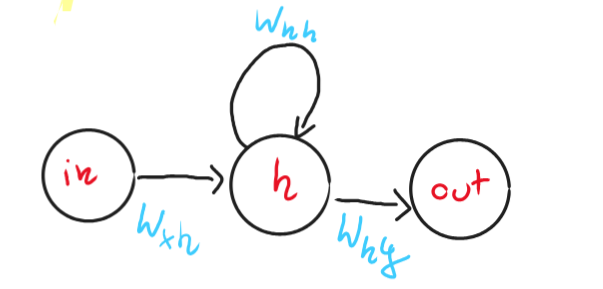

One of the most important concepts in RNNs is unrolling - that means picturing network cells for different timestamps as separate neurons. Below picture shows network presented above unrolled for 3 timesteps.

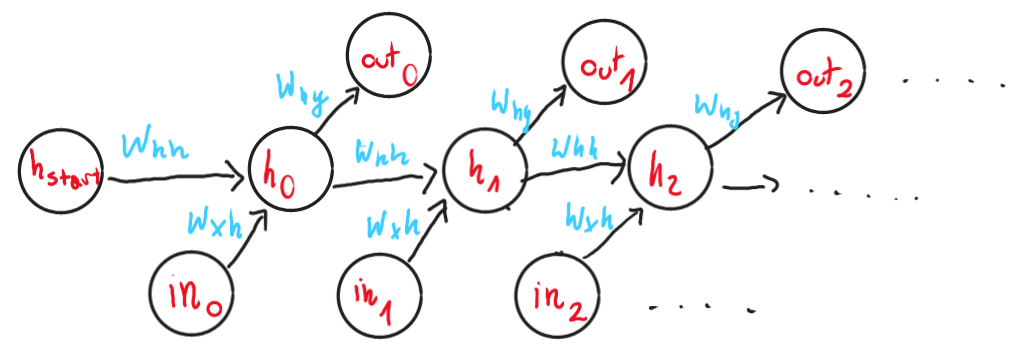


Network takes as input initial hidden state -  $h_{start}$, usually initialized to 0.
In timestep $t = 1$ network takes two inputs - $h_0$ (hidden state from previous timestep) and $x_1$ (input at timestep 1), produces two outputs - $h_1$ that is passed to next timestep and $y_1$ that is output for this timestep.

During forward pass at timestep $t$ such neural network does following computations:
1) calculate hidden activations $h_t = tanh(W_{hh} \cdot h_{t - 1} + W_{xh} \cdot x_t )$*
2) produce output $ y_t = h_t \cdot W_{hy}$

\* tanh is used as activation function, but it can be anything (relu/sigmoid)

These steps are calculated at each timestep using the same wieghts. 

Like in dense NNs, hidden layer can have different shape than input. If for example we have 1-D input, 4 hidden units, which implies 4-D output. If we want to get 1-D output dense layer on top of RNN is required. Shapes of whole network (RNN + Dense) components are:

Shapes below are result of setting return_sequences for RNN to False - that means that RNN layer will return only last output

- $x$ = (n_batches, n_timesteps, 1) - input
- $W_{xh}$ = (1, 4)
- $h$ = (1, 4) - hidden layer output - calculated at each step
- $W_{hy}$ = (4, 4)
- $W_{hy}$ = (4, 4)
- $y_{hidden}$ = (n_batches, 4) - output - result of running n_batches through RNN
- $W_{dense}$ = (4,  1) - weights of dense layer
- $y_{dense}$ = (n_batches, 1) - output

If we set return_sequences to True shapes are as follows:

- $x$ = (n_batches, n_timesteps, 1) - input
- $W_{xh}$ = (1, 4)
- $h$ = (1, 4) - hidden layer output - calculated at each step
- $W_{hy}$ = (4, 4)
- $W_{hy}$ = (4, 4)
- $y_{hidden}$ = (n_batches, n_timesteps, 4) - output - result of running n_batches through RNN
- $W_{dense}$ = (4,  1) - weights of dense layer, applied at each timestep
- $y_{dense}$ = (n_batches, n_timesteps, 1) - output


Below is example code that defines such networks

In [48]:
timesteps = 5
# not returning sequences
inputs = keras.Input(shape=(timesteps, 1), name="inputs")
hidden = keras.layers.SimpleRNN(4, name="hidden", return_sequences=False)(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()
# returning sequences
inputs = keras.Input(shape=(timesteps, 1), name="inputs")
hidden = keras.layers.SimpleRNN(4, name="hidden", return_sequences=True)(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden (SimpleRNN)          (None, 4)                 24        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden (SimpleRNN)          (None, 5, 4)   

#### Stacking RNNs
RNNs can be stacked to create multiple layers. In such configuration at each timestep output from first RNN is passed as input for another one. In such case all layers that pass outputs to another layer, must return sequences, so each timestep is passed.
If we would want to pass just last output, it would create encoder - decoder architecture, which will be explained later. Below is example architecture definition that stacks RNN layers.

In [6]:
timesteps = 5
inputs = keras.Input(shape=(timesteps, 1), name="inputs")
hidden1 = keras.layers.SimpleRNN(4, name="hidden1", return_sequences=True)(inputs)
hidden2 = keras.layers.SimpleRNN(5, name="hidden2", return_sequences=True)(hidden1)
hidden3 = keras.layers.SimpleRNN(6, name="hidden3", return_sequences=False)(hidden2)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden3)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden1 (SimpleRNN)         (None, 5, 4)              24        
                                                                 
 hidden2 (SimpleRNN)         (None, 5, 5)              50        
                                                                 
 hidden3 (SimpleRNN)         (None, 6)                 72        
                                                                 
 out (Dense)                 (None, 1)                 7         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


## LSTMs
### General concept
Similarly to how simple RNNs, LSTMs are built from cells. Here cell structure is a little more complicated — each cell has 3 inputs and 2 outputs. Outputs of each cell are:
- $c$ - called "state", because it transports data between timesteps, while undergoing little modification at each timestep, which allows for capturing long time dependencies (also called "Long Term Memory")
- $h$ - being output of given cell. It is modified at every step depending on $c$, previous timestep's output and current input, which allows for capturing short time dependencies (also called "Short Term Memory")

Inputs for each cell are $h$ and $c$ from previous cell and $x$ at given timestep.

Having this 2 tensors $h$, $c$ passed between timesteps allows this architecture to learn both long and short term dependecies in data - that's why it's called Long Short Term Memory.

### Cell's internal structure
Each cell has 3 main components:
- forget gate responsible for selecting which elements of state passed from previous timestep will be forgotten and which will be used to produce output and passed to next timestep
- input gate responsible for updating state
- output gate responsible for deciding how state will affect output and producing it

Each component is modeled using neural network and has it's own set of weights.

- Forget gate is single neural network that on given timestep $t$, based on $h_{t-1}$, $x_t$ and weights $w_f$ produces vector $f$. Sigmoid is used as activation function, so $f$ elements $\in <0, 1>$. $f$ is multiplied element-wise with state $c_{t-1}$ - this operation decides which elements of $c_{t-1}$ will be forgotten.
- Input gate consists of 2 neural networks, both taking $h_{t-1}$, $x_t$ as input.
    - First one produces candidate state $C$ based on $W_c$ set of weights. It uses tanh activation function (since $c$ elements $\in <-1; 1>$)
    - Second one is responsible for deciding how candidate state $C$ will affect state $c$ passed to next step and used to produce output. Based on weights $W_i$ it produces tensor $i$, which elements $\in <0; 1>$ because sigmoid activation is used.
    - Outputs of these networks are multiplied with each other element-wise and then added to $c_{t-1} \cdot f$ (produced by forget gate) in order to produce state $c_t$. 
- Output gate consists of single neural network, with sigmoid activation, which decides how state $c_t$ will affect output $h_t$. Based on weights $w_o$ it produces $o$ vector, which is multilpied element-wise with $tanh(c_t)$ in order to produce output $h_t$. $tanh$ is used here to squeeze $c$ to $<-1; 1>$.

Picture below ilustrates in greater detail how LSTM cell works.
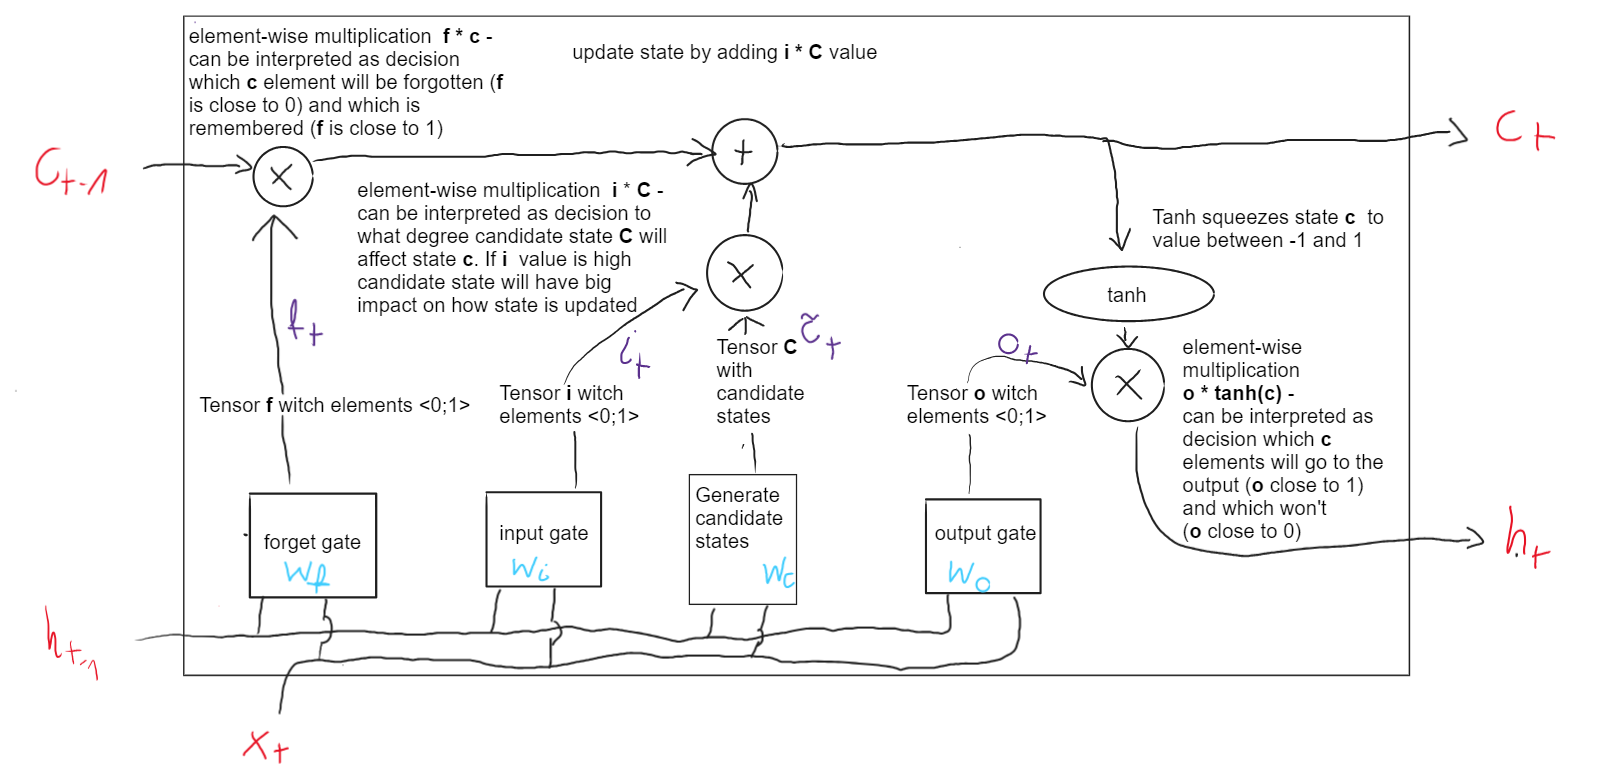


### What computations are done in every cell
1) $f_t = sigmoid(w_f \cdot [h_{t-1}, x_t])$
2) $c_t = c_{t-1} \cdot f_t$
3) $C_t = tanh(w_c \cdot [h_{t-1}, x_t])$
4) $i_t = sigmoid(w_i \cdot [h_{t-1}, x_t])$
5) $c_t$ += $i_t \cdot C_t$
6) $o_t = sigmoid(w_o \cdot [h_{t-1}, x_t])$
7) $h_t = o_t \cdot tanh(c_t)$

### Example
In keras LSTMs are used exactly the same as regular RNNs, so parameter passed as number of units determines dimensionality of $h_t$.

Let's say we want to create a network that based on 1-D data predicts next step in that data. Our network will have 2 stacked LSTMs - one with 10 hidden units, second with 15 units and dense layer to aggregate this data into 1 predicted point in time. We can set return_sequences=True for last LSTM layer, so our model will learn to predict next value at each timestep, which means we can predict sequences of arbitrary length by just feeding previous output as input to next step. Then if our input series is $[1, 2, 3, 4, 5, 6]$ we can set model inputs and outputs to $x = [1, 2, 3, 4, 5]$, $y = [2, 3, 4, 5, 6]$. If we didn't set return_sequences to True we would teach our model to first take $n$ timesteps, then predict.

In [2]:
timesteps = 5
inputs = keras.Input(shape=(timesteps, 1), name="inputs")
hidden1 = keras.layers.LSTM(10, name="hidden1", return_sequences=True)(inputs)
hidden2 = keras.layers.LSTM(15, name="hidden2", return_sequences=True)(hidden1)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden2)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden1 (LSTM)              (None, 5, 10)             480       
                                                                 
 hidden2 (LSTM)              (None, 5, 15)             1560      
                                                                 
 out (Dense)                 (None, 5, 1)              16        
                                                                 
Total params: 2,056
Trainable params: 2,056
Non-trainable params: 0
_________________________________________________________________


Let's take a closer look at weights of first LSTM.
Inputs for it will be shape $(n, 5, 1)$, and cell has 10 units so
LSTM cell at given timestep will take following parameters:

(omitting batch size)
- $h_t = (10)$
- $c_t = (10)$
- $x_t = (1)$
- $w_f = w_i = w_c = w_o =(11, 10) $ - shape of $h_t$ joined with $x_t$ by shape of $c_t$

## Autoencoders
### Architecture
After understanding LSTMs, autoencoders are quite simple architecture. Problem that they solve is creating output of different length than input. With RNNs we can predict multiple timesteps ahead, but it's done by running multiple timesteps with predictions as inputs to next timesteps, but we can't explicitly teach the model to predict $n$ timesteps ahead. The main idea behind autoencoders it to create 2 separate networks : 
- encoder, that encodes the data into context vector,that contains all the information necessary to make predictions
- decoder, that based on context vector produces final predictions

When it comes to time series processing, basic encoder-decoder setups use RNNs (or their variations like LSTMs) as building blocks for both parts of the architecture. Context vector is usually final hidden state of encoder, with which decoder hidden state is initialized.

Encoder-decoder architecture is derived from seq2seq problems like translation, where during training decoder input at timestamp $t$ is set to correct translated value of previous timestep $y_{t-1}$ - setting inputs to decoder in such way is called teacher forcing. In time series prediction tasks, teacher forcing isn't ideal way to teach decoder, since usually time series value at $t$ is highly correlated with value at $t-1$, so decoder learns to make predictions based on previous value (which during inference will be predicted value of previous timestep, not true one) instead of context vector. This leaves us with 2 possible ways of setting decoder inputs during training - either to 0 or to elements of context vector.

Picture below portraits high-level architecture of encoder-decoder setup

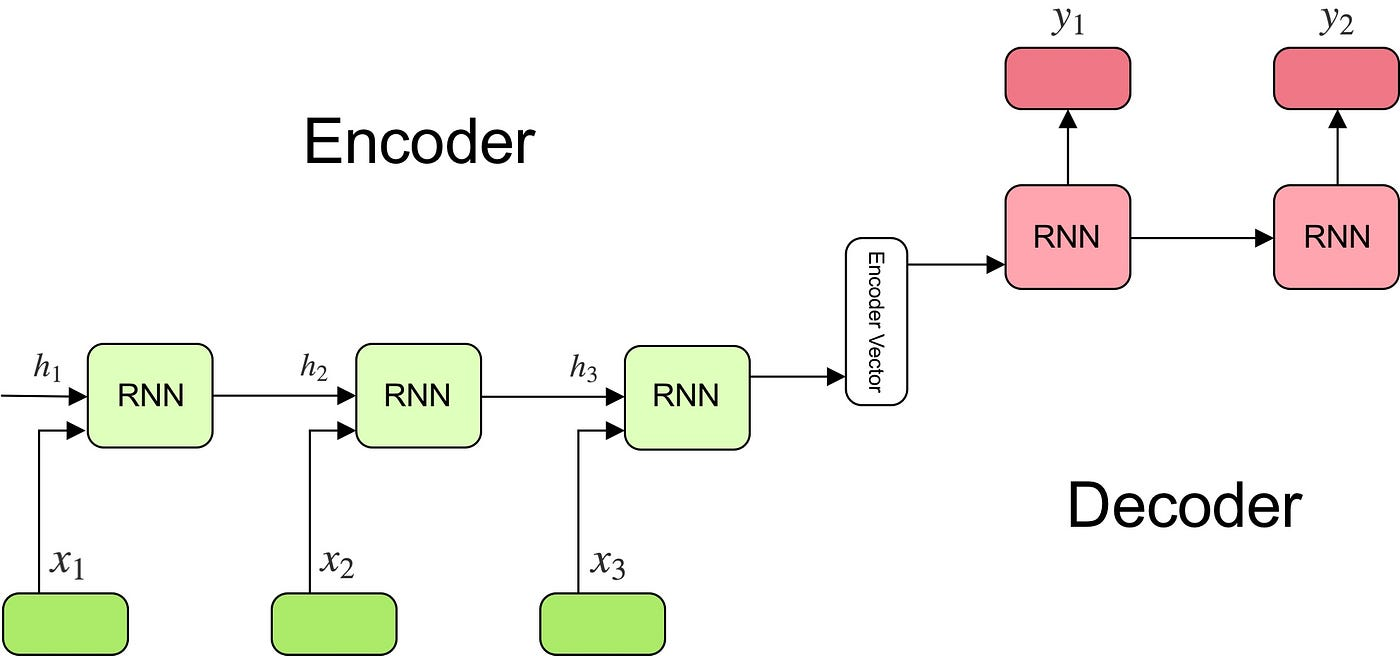

### Example
In this example we will define encoder-decoder architecture with 10-unit LSTMs as both encoder and decoder. Such setup can predict arbitrary number of timesteps ahead based on arbitraty number of input timesteps. Nubmer of input and output timesteps will be defined by dataset on which it will be trained. Here input timesteps number will be set to 5 in order to better ilustrate layer output dimensions and output timesteps will be set to 2, to simplify code (for arbitrary number of outputs custom layer would need to be defined, here we'll just use RepeatVector to serve as decoder inputs at each timestep).

In [17]:
input_timesteps = 5
output_timesteps = 2
batch_size = 1

encoder_inputs =  keras.layers.Input(shape=(input_timesteps, 1))
encoder = keras.layers.LSTM(10, return_state=True, return_sequences=False)
# state_h and state_c are context vector
# encoder_outputs are discarded (they are the same as state_h since LSTM is used)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# using hidden state h from encoder as inputs at each decoder timestep
# decoder =  keras.layers.RepeatVector(output_timesteps)(state_h)
# using zeros as inputs at each decoder timestep
decoder =  keras.layers.RepeatVector(output_timesteps)(tf.zeros((batch_size, 1)))

decoder_lstm =  keras.layers.LSTM(10, return_sequences=True, return_state=False)
decoder = decoder_lstm(decoder, initial_state=[state_h, state_c])

# using dense layer to aggregate 10-D LSTM output
# using TimeDistributed to make it clear that dense layer is applied to every timestep separately
# but it does not make any real difference (i believe)
out =  keras.layers.TimeDistributed(keras.layers.Dense(1))(decoder)
model =  keras.models.Model(encoder_inputs, out)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_23 (LSTM)                 [(None, 10),         480         ['input_15[0][0]']               
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 lstm_24 (LSTM)                 (1, 2, 10)           480         ['lstm_23[0][1]',                
                                                                  'lstm_23[0][2]']         

## Attention
TODO: uzupełnić teorię

In [16]:
input_timesteps = 5
output_timesteps = 2
batch_size = 1

encoder_inputs =  keras.layers.Input(shape=(input_timesteps, 1))
encoder = keras.layers.LSTM(10, return_state=True, return_sequences=False, name="encoder")
# state_h and state_c are context vector
# encoder_outputs are discarded (they are the same as state_h since LSTM is used)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# using hidden state h from encoder as inputs at each decoder timestep
# decoder =  keras.layers.RepeatVector(output_timesteps)(state_h)
# using zeros as inputs at each decoder timestep
decoder =  keras.layers.RepeatVector(output_timesteps)(tf.zeros((batch_size, 1)))

decoder_lstm =  keras.layers.LSTM(10, return_sequences=True, return_state=False, name="decoder")
decoder_outputs = decoder_lstm(decoder, initial_state=[state_h, state_c])

attention = keras.layers.Attention(name="attention")
attention_outputs = attention([decoder_outputs, encoder_outputs])

dense_inputs = keras.layers.Concatenate()([attention_outputs, decoder_outputs])
# using dense layer to aggregate 10-D LSTM output
# using TimeDistributed to make it clear that dense layer is applied to every timestep separately
# but it does not make any real difference (i believe)
out =  keras.layers.Dense(1)(dense_inputs)
model =  keras.models.Model(encoder_inputs, out)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 encoder (LSTM)                 [(None, 10),         480         ['input_14[0][0]']               
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 decoder (LSTM)                 (1, 2, 10)           480         ['encoder[0][1]',                
                                                                  'encoder[0][2]']         